In [2]:
import pandas as pd
import numpy as np
dgeo=pd.read_csv(header=None,sep="\t",filepath_or_buffer="/datastore/complexnet/jlevyabi/geoloc/txt_files/precise_locs.txt")
dgeo.columns=["usr","time","lat","lon"]


In [3]:
from datetime import date,timedelta
from tqdm import tqdm

def time_2_date(time_array):
    days=[];hours=[];years=[];months=[]
    for times in tqdm(time_array):
        tab_date=times.split('-')
        fecha=(date(int(tab_date[0]),int(tab_date[1]),int(tab_date[2][:2]))).weekday()
        hour=int(times.split('T')[1][:2])
        year=tab_date[0]
        month=tab_date[1]
        years.append(year)
        days.append(fecha)
        hours.append(hour)
        months.append(month)
    return days,hours,years,months

days,hours,years,month=time_2_date(dgeo.time)
dgeo['day']=days;dgeo['hour']=hours;dgeo['year']=years;dgeo['month']=month;
dgeo=dgeo.drop(labels="time",axis=1)

100%|██████████| 466491/466491 [00:08<00:00, 55649.20it/s]


In [4]:
work_hours=range(8,20)
home_hours=list(set(range(24))-set(work_hours))
work_days=range(5)
home_days=list(set(range(7))-set(work_days))
dgeo_work=dgeo[dgeo.day.isin(work_days) & dgeo.hour.isin(work_hours)]#.drop(["day","hour"],axis=1)
dgeo_home=dgeo[dgeo.day.isin(home_days) | dgeo.hour.isin(home_hours)]#.drop(["day","hour"],axis=1)

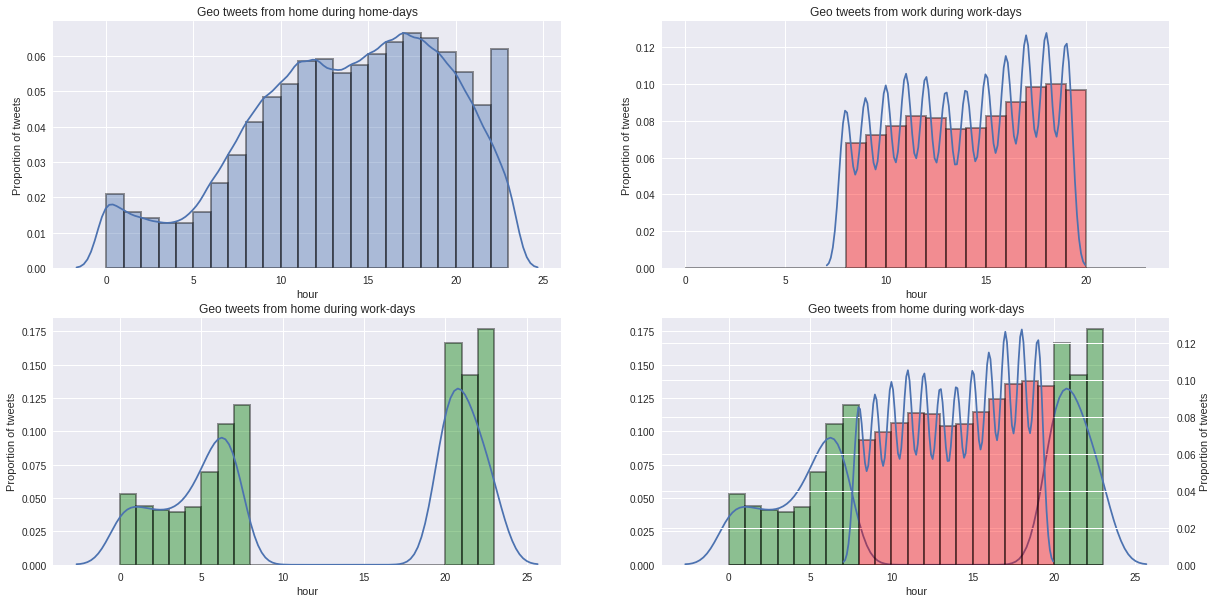

In [97]:
import seaborn as sns
sns.plt.figure(figsize=(20,10))
sns.plt.subplot(221)
sns.distplot(bins=range(24),a=dgeo_home.hour[dgeo_home.day.isin(home_days)],hist_kws=dict(edgecolor="k", linewidth=2))
sns.plt.ylabel('Proportion of tweets')
sns.plt.title('Geo tweets from home during home-days')
sns.plt.subplot(222)
sns.distplot(bins=range(24),a=dgeo_work.hour[dgeo_work.day.isin(work_days)],hist_kws=dict(color= "r",edgecolor="k", linewidth=2))
sns.plt.ylabel('Proportion of tweets')
sns.plt.title('Geo tweets from work during work-days')
sns.plt.subplot(223)
sns.distplot(bins=range(24),a=dgeo_home.hour[dgeo_home.day.isin(work_days)],hist_kws=dict(color= "g",edgecolor="k", linewidth=2))
sns.plt.ylabel('Proportion of tweets')
sns.plt.title('Geo tweets from home during work-days')
sns.plt.subplot(224)
ax1=sns.distplot(bins=range(24),a=dgeo_home.hour[dgeo_home.day.isin(work_days)],
                 hist_kws=dict(color= "g",edgecolor="k", linewidth=2))
ax2=ax1.twinx()
sns.distplot(bins=range(24),a=dgeo_work.hour[dgeo_work.day.isin(work_days)],
             hist_kws=dict(color= "r",edgecolor="k",linewidth=2),ax=ax2)
sns.plt.ylabel('Proportion of tweets')
sns.plt.title('Geo tweets from home during work-days')

sns.plt.show()

In [112]:
dgeo_home.shape

(252019, 7)

In [5]:
d=dgeo_home.groupby(['lat', 'lon','month','year']).size().reset_index(name='Freq').sort_values(by=['Freq'],axis=0, ascending=False)
d.head()
#48.856700  2.350800

,lat,lon,month,year,Freq
115571,48.884700,2.239600,10,2017,834
117647,48.898900,2.093800,10,2017,736
70595,47.257222,1.932222,08,2016,668
72168,47.433889,2.553611,03,2016,646
72169,47.433889,2.553611,04,2016,574


In [6]:
d=dgeo_home.groupby(['lat', 'lon','usr']).size().reset_index(name='Freq').sort_values(by=['Freq'],axis=0, ascending=False)
d.head()

,lat,lon,usr,Freq
106194,48.856900,2.341200,1305509970,2604
72158,47.433889,2.553611,2799922333,2184
101226,48.848397,2.374133,184454249,1858
70565,47.257222,1.932222,2799922333,1807
30286,41.235863,-96.052630,497145453,1737


In [27]:
from collections import Counter
import time

def fast_get_most_frequent_location(d_home):
    dic={}
    for index,row in tqdm(d_home.iterrows()):
        usr,lat,lon=row.usr,row.lat,row.lon
        if usr not in dic:dic[usr]=[(lat,lon)]
        else:dic[usr].append((lat,lon))
    res=[]
    for usr,visits in tqdm(dic.items()):
        visit_usrs=Counter(visits)
        most_freq=visit_usrs.most_common(1)[0]
        res.append((usr,most_freq[0][0],most_freq[0][1],most_freq[1],sum(visit_usrs.values()),
                    (most_freq[1]+0.0)/sum(visit_usrs.values())))
    return(dic,pd.DataFrame(data=res,columns=["usr","lat","lon","nb_loc","total_geo","proba"]))

def get_most_frequent_location(d_home):
    grouped = d_home.groupby('usr');res=[]
    for name,d_pre_usr in tqdm(grouped):
        
        d_pre_usr=d_pre_usr.groupby(["lat", "lon"]).size().reset_index(name="time")
        d_pre_usr_max_loc=d_pre_usr.ix[d_pre_usr.time.idxmax()]
        total_locs=np.sum(d_pre_usr.time)
        d_pre_usr_max_loc['usr']=str(name)
        d_pre_usr_max_loc['nb_loc']=total_locs+0.0
        d_pre_usr_max_loc['proba']=d_pre_usr_max_loc.time/total_locs
        res.append(d_pre_usr_max_loc)
    return((res))

dic_locs,pre_home=fast_get_most_frequent_location(dgeo_home)
#pre_home.to_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/dgeo_home_most_freq.csv',header=True,index=None,sep=',')

252019it [02:03, 2048.20it/s]
100%|██████████| 45443/45443 [00:02<00:00, 16739.01it/s]


In [34]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],[8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
to_remove=[]
new_dic_locs={}
for usr, locs in tqdm(dic_locs.items()):
    isinfrance=False
    locs_france=[]
    for loc in locs:
        if france.contains(Point(reversed(loc))):
            isinfrance=True
            locs_france.append(loc)
    if len(locs_france)>0:
        new_dic_locs[usr]=locs_france

100%|██████████| 45443/45443 [00:28<00:00, 1613.08it/s]


In [35]:
i=0
for k,v in new_dic_locs.items():
    i+=1
    if i>1000: break
    print ("\n"+str(k))
    if len(v)>100: continue
    for loc in v:
        try:
            print((str(loc[0])+","+str(loc[1])))
        except:
            pass


1469650915
43.6119,3.8772

1927804950
49.0588975,2.0834064

1122777066
48.86356463,2.38868023
49.05046852,2.07847396
43.6,1.43333

58086598
48.8667,2.4333299999999998

205306385
48.8567,2.3508
48.8567,2.3508
48.8567,2.3508
45.09333333,1.93777778
45.09333333,1.93777778
49.2,0.35
48.85798,2.3673599999999997

281555005
43.748502,7.4436919999999995
43.74467884,7.39971442
48.84337963,2.32467592
43.733289899999995,7.418130000000001
43.73529079,7.42246929
43.727778,7.415556
43.72795587,7.41540444
43.65886846,7.19733238
48.70361694,2.6010642
48.86169391,2.34485149

586890533
48.95651699,2.38216896

42037704
48.600707,7.717263000000001
48.5814,7.7514199999999995
48.582199100000004,7.749730099999999

61746580
43.69516415,7.26303997

1031321473
43.151327,3.179215
43.22196895,2.37330526
43.22323,2.34996
43.19984,2.35618333
43.20033,2.35724
43.6119,3.8772

108945681
48.11572863,-4.33669595
46.489081,-1.790185
43.54862,4.112565
43.55658519,4.08245497
43.55565794,4.0806786
43.5593443,4.07991

124746

In [130]:
d_geo_home_freq=pre_home

In [104]:
import pandas as pd
d_geo_home_freq=pd.read_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/dgeo_home_most_freq.csv',
                       sep=',')

In [131]:
d_geo_home_freq.head()

,usr,lat,lon,nb_loc,total_geo,proba
0,818306215,16.265678,-61.634376,1,1,1.000000
1,383343078,14.641547,-61.046039,10,70,0.142857
2,1976835420,-12.789172,45.270077,1,16,0.062500
3,300514474,14.502121,-60.903963,6,55,0.109091
4,2383410383,16.223386,-61.453476,5,13,0.384615


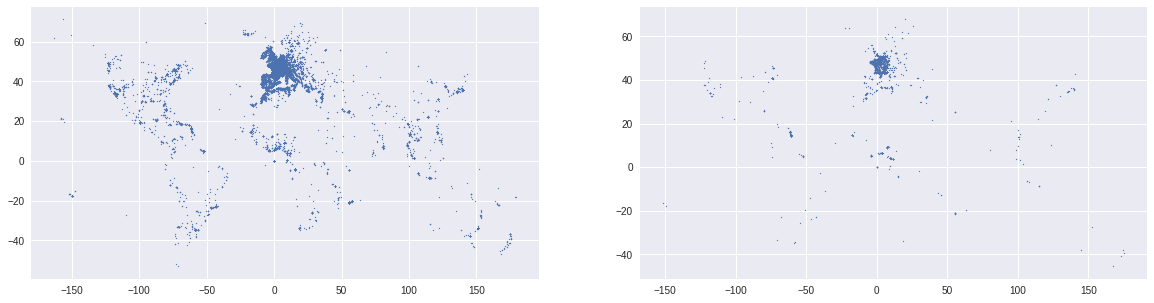

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(d_geo_home_freq.lon,d_geo_home_freq.lat,s=1)
plt.subplot(122)
plt.scatter(d_geo_home_freq.lon[d_geo_home_freq.total_geo>10],d_geo_home_freq.lat[d_geo_home_freq.total_geo>10],s=1)
plt.show()

In [137]:
d_geo_home_freq.lon[d_geo_home_freq.total_geo>50].shape

(409,)

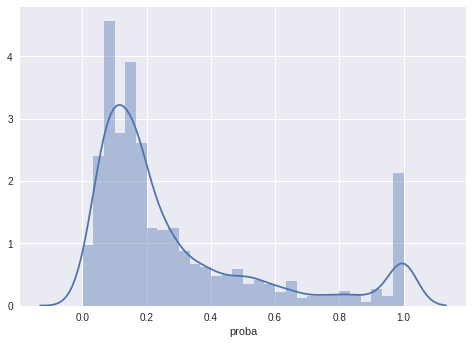

In [138]:
import seaborn as sns
sns.distplot(d_geo_home_freq.proba[d_geo_home_freq.total_geo>10],bins=30)
sns.plt.show()